# Finite differences in 1D

We approximate the boundary value problem consisting of the PDE
$$
-u''(x) + u(x) = f(x), \qquad  0 < x < 1
$$
with  Dirichlet boundary conditions 
$$
u(0) = u(1) = 0
$$
using finite differences. This notebook also serves as a quick introduction to python and numpy. Please see Python Resources in the syllabus for learning more about basic numerical facilities in python.

In [1]:
import numpy as np

### Making the finite difference system

The matrix of the *central second finite difference* operator on a grid of 5 equally spaced points, two of which have zero boundary conditions, can be "made by hand" as a `numpy` array, as follows. 

In [2]:
A = np.array([[ 2, -1,  0], 
              [-1,  2, -1], 
              [ 0, -1,  2]])
A

array([[ 2, -1,  0],
       [-1,  2, -1],
       [ 0, -1,  2]])

For large number of grid points, we need an automatic way to make this matrix. Numpy provides many ways to create matrices quickly. For example, the `diag` command generates matrices with input entries in the diagonal, superdiagonals, or subdiagonals.

In [3]:
N = 10
2 * np.diag(np.ones(N))

array([[2., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 2., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 2., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 2., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 2., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 2., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 2., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 2., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 2., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]])

In [4]:
A = 2 * np.diag(np.ones(N)) +    \
    np.diag(-np.ones(N-1), -1) + \
    np.diag(-np.ones(N-1), 1)  + \
    np.eye(N)
A

array([[ 3., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  3., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0., -1.,  3., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0., -1.,  3., -1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0., -1.,  3., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0., -1.,  3., -1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  3., -1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., -1.,  3., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  3., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  3.]])

### Solving the difference equation system

We solve the finite difference equations using the built-in inverse routine in numpy's `linalg` submodule. Note how we create functions using `def` in python and how we use `@` for numpy matrix multiply.

In [5]:
def solve(f, h):
    size = len(f)
    A = (1/h**2) * (2 * np.diag(np.ones(size))    + \
                    np.diag(-np.ones(size-1), -1) + 
                    np.diag(-np.ones(size-1), 1)) + np.eye(size)
    return np.linalg.inv(A) @ f

### Check for correctness

We will verify that the `solve` function is solving as expected by the *method of manufactured solutions*, which is a trivial method: pick your favorite solution function $u$ satisfying the boundary conditions,  then generate the right hand side $f$ by applying the differential operator to $u$. In the check below, I will use
$$
u = \sin(x)
$$
on an interval $(0, 3\pi)$ so that the zero boundary conditions hold. Then put $f = -u'' + u = 2\sin(x)$. Let's provide this $f$ to `solve` and see whether it outputs an approximation to $u = \sin(x)$.

An equally spaced grid in an interval is easily made using the `linspace` facility.

In [6]:
np.linspace(0, 3*np.pi, num=10)

array([0.        , 1.04719755, 2.0943951 , 3.14159265, 4.1887902 ,
       5.23598776, 6.28318531, 7.33038286, 8.37758041, 9.42477796])

Let's make the data $f$ for the manufactured solution $u=\sin(x)$.

In [7]:
N = 30    # the system becomes more expensive to solve for large N
h = 3*np.pi / N
x = np.linspace(0, 3*np.pi, num=N)
f = 2 * np.sin(x)

When we solve, we make sure not to give the end point values in `f` (as the solution there is already determined by the boundary conditions).  Restricting $f$ outside of these points is done by *slicing* in numpy (which you should definitely learn if you don't know already) as in `f[1:-1]`.

In [8]:
u = solve(f[1:-1], h)

For visualizing the solution, we use `matplotlib` module.

In [9]:
import matplotlib.pyplot as plt

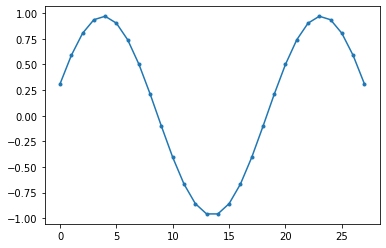

In [10]:
plt.plot(u, '.-')

How can you make sure the end points with zero solution values  are also included in the final plot? Again by slicing: 

In [11]:
uu = np.zeros(N)
uu[1:-1] = u

Let's conclude by comparing the exact solution with the numerical solution by plotting both in the same scene. 

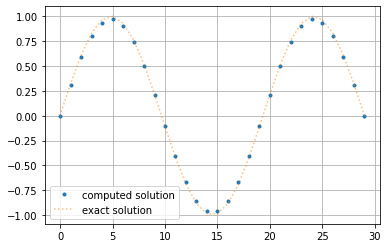

In [12]:
plt.plot(uu, '.', label='computed solution')
plt.plot(np.sin(x), ':', label='exact solution', alpha=0.5)
plt.grid(True)
plt.legend();

Clearly, the `solve` function captured something close to the exact solution.